In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("--- Starting Superstore Analysis ---")

# Create directory for saving plots if it doesn't exist!
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# Set plot style
sns.set_style('whitegrid')

--- Starting Superstore Analysis ---


In [9]:
# --- 1. Data Loading ---
print("\n--- 1. Loading Data ---")
file_path = 'Superstore.csv' # Make sure this file is in the same directory as your notebook
df = None # Initialize df

try:
    # Use specified encoding, handle potential quoting issues
    df = pd.read_csv(file_path, encoding='windows-1252', quotechar='"', low_memory=False)
    print(f"Dataset loaded successfully from {file_path}.")
    print(f"Initial Shape: {df.shape}")
    print("\nDataset Head:")
    print(df.head())
    print("\nData Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: Dataset file not found at {file_path}. Please ensure Superstore.csv is in the correct directory.")
    # In a notebook, you might not want to exit, just stop execution of this path
    raise # Re-raise the error to stop notebook execution here if the file isn't found
except Exception as e:
    print(f"An error occurred during loading: {e}")
    raise # Re-raise other errors

# Check if df loaded before proceeding
if df is None:
    print("DataFrame failed to load. Cannot continue.")
    # Stop execution if df is None
    assert df is not None, "DataFrame loading failed."



--- 1. Loading Data ---
Dataset loaded successfully from Superstore.csv.
Initial Shape: (9994, 21)

Dataset Head:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fo

In [10]:
# --- 2. Data Cleaning and Preparation ---
print("\n--- 2. Cleaning Data ---")

# Check if df exists from Cell 2
if 'df' not in locals() or df is None:
    print("Error: DataFrame 'df' not found. Please run Cell 2 (Data Loading) first.")
else:
    # Standardize column names (lowercase, replace space/hyphen with underscore)
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
    print("Cleaned Column Names:")
    print(df.columns)

    # Check for missing values
    print("\nMissing Values per Column (Before Handling):")
    print(df.isnull().sum())

    # Check for duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")

    # Remove duplicates if any
    if duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f"Duplicate rows removed. New shape: {df.shape}")
    else:
        print("No duplicate rows found.")

    # Convert date columns to datetime objects
    date_cols = ['order_date', 'ship_date']
    print("\nConverting date columns...")
    for col in date_cols:
        if col in df.columns:
            try:
                # Let pandas infer the format, coerce errors to NaT (Not a Time)
                df[col] = pd.to_datetime(df[col], errors='coerce')
                print(f"Attempted conversion for '{col}'.")
                # Check if any values failed to convert
                if df[col].isnull().any():
                     print(f"Warning: Some values in '{col}' could not be converted to datetime and are now NaT.")
            except Exception as e:
                print(f"Could not convert {col} to datetime due to an error: {e}")
        else:
            print(f"Column '{col}' not found, skipping conversion.")


    print("\nData types after date conversion:")
    df.info()

    # Report remaining missing values after initial cleaning
    print("\nMissing Values After Initial Cleaning:")
    missing_after = df.isnull().sum()
    print(missing_after[missing_after > 0])

    # Note: The original script didn't explicitly handle missing values beyond reporting them.
    # We might add imputation (filling missing values) later if needed for specific analyses.
    print("\n--- Data Cleaning Finished ---")



--- 2. Cleaning Data ---
Cleaned Column Names:
Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Missing Values per Column (Before Handling):
row_id           0
order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
customer_name    0
segment          0
country          0
city             0
state            0
postal_code      0
region           0
product_id       0
category         0
sub_category     0
product_name     0
sales            0
quantity         0
discount         0
profit           0
dtype: int64

Number of duplicate rows: 0
No duplicate rows found.

Converting date columns...
Attempted conversion for 'order_date'.
Attempted conversion for 'ship_date'.

Data types after date co

In [14]:
# --- 3. SQL Analysis (using SQLite) ---
print("\n--- 3. SQL Analysis (using SQLite) ---")

# Check if df exists and is not empty before proceeding
if 'df' in locals() and not df.empty:
    try:
        # Connect to an in-memory SQLite database
        conn = sqlite3.connect(':memory:')
        print("Connected to in-memory SQLite database.")

        # Load the cleaned DataFrame into an SQL table named 'superstore'
        # Replace table if it already exists (useful for re-running cells)
        df.to_sql('superstore', conn, index=False, if_exists='replace')
        print("Data loaded into SQLite table 'superstore'.")

        # Example SQL Query: Total Sales per Region
        print("\nExecuting SQL Query: Total Sales per Region")
        query_sales_region = "SELECT region, SUM(sales) as total_sales FROM superstore GROUP BY region ORDER BY total_sales DESC"
        sales_by_region = pd.read_sql_query(query_sales_region, conn)
        print("Query Results:")
        print(sales_by_region)

        # Example SQL Query: Top 10 Products by Sales (WITH LIMIT 10)
        print("\nExecuting SQL Query: Top 10 Products by Sales")
        query_top_products = "SELECT product_name, SUM(sales) as total_sales FROM superstore GROUP BY product_name ORDER BY total_sales DESC LIMIT 10" # <-- LIMIT 10 is back
        top_products = pd.read_sql_query(query_top_products, conn)

        # --- Force display of more rows ---
        print("\nTop 10 Products (forcing display):")
        original_max_rows = pd.get_option('display.max_rows') # Store original setting
        pd.set_option('display.max_rows', 15) # Temporarily show up to 15 rows

        print(top_products) # Print the table with the new setting

        pd.set_option('display.max_rows', original_max_rows) # Reset to original setting
        # --- End force display ---

        print(f"\nShape of top_products DataFrame: {top_products.shape}") # Confirm shape

        # Close the connection
        conn.close()
        print("\nSQLite connection closed.")

    except Exception as e:
        print(f"An error occurred during SQL analysis: {e}")
        # Close connection if it exists, even if an error occurred
        if 'conn' in locals() and conn:
            conn.close()
            print("SQLite connection closed after error.")
else:
    print("DataFrame 'df' not found or is empty. Skipping SQL analysis.")

print("\n--- SQL Analysis Finished ---")


--- 3. SQL Analysis (using SQLite) ---
Connected to in-memory SQLite database.
Data loaded into SQLite table 'superstore'.

Executing SQL Query: Total Sales per Region
Query Results:
    region  total_sales
0     West  725457.8245
1     East  678781.2400
2  Central  501239.8908
3    South  391721.9050

Executing SQL Query: Top 10 Products by Sales

Top 10 Products (forcing display):
                                        product_name  total_sales
0              Canon imageCLASS 2200 Advanced Copier    61599.824
1  Fellowes PB500 Electric Punch Plastic Comb Bin...    27453.384
2  Cisco TelePresence System EX90 Videoconferenci...    22638.480
3       HON 5400 Series Task Chairs for Big and Tall    21870.576
4         GBC DocuBind TL300 Electric Binding System    19823.479
5   GBC Ibimaster 500 Manual ProClick Binding System    19024.500
6               Hewlett Packard LaserJet 3310 Copier    18839.686
7  HP Designjet T520 Inkjet Large Format Printer ...    18374.895
8          GBC Docu


--- 4. Python EDA & Visualization ---

--- Sales and Profit Analysis ---
Total Sales: $2,297,200.86
Total Profit: $286,397.02
Overall Profit Margin: 12.47%

Generating Sales/Profit over time plots...
Saved plot: plots/monthly_sales.png


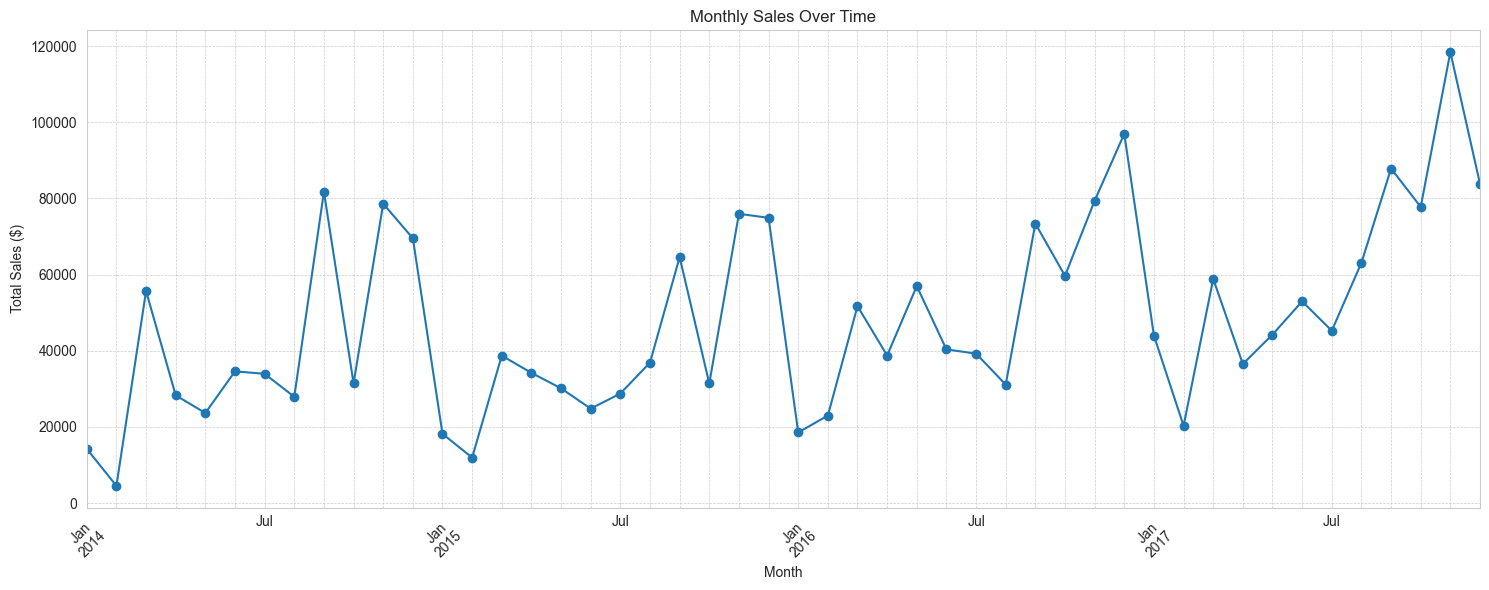

Saved plot: plots/monthly_profit.png


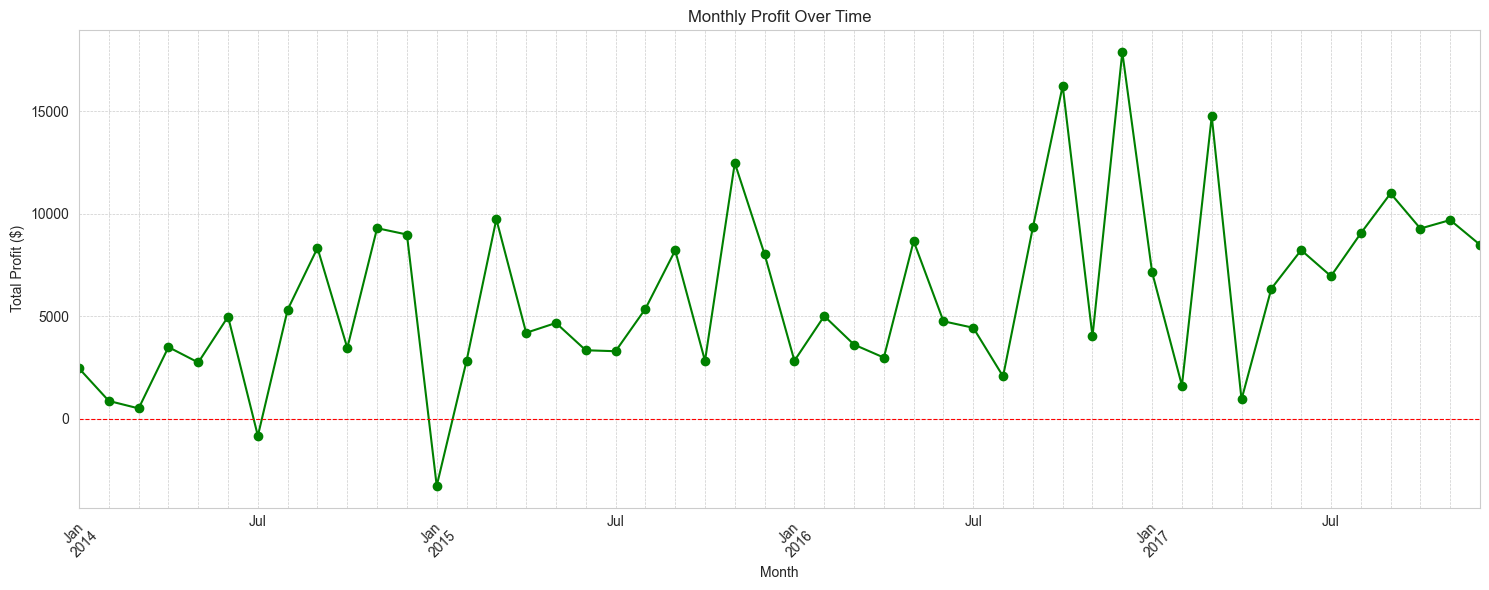


--- Time Series Analysis Finished ---


In [15]:
# --- 4. Python-based Exploratory Data Analysis (EDA) & Visualization ---
print("\n--- 4. Python EDA & Visualization ---")

# Check if df exists before proceeding
if 'df' in locals() and not df.empty:

    # --- Sales and Profit Overview ---
    print("\n--- Sales and Profit Analysis ---")
    if 'sales' in df.columns and 'profit' in df.columns:
        total_sales = df['sales'].sum()
        total_profit = df['profit'].sum()
        print(f"Total Sales: ${total_sales:,.2f}")
        print(f"Total Profit: ${total_profit:,.2f}")
        if total_sales != 0:
            profit_margin = (total_profit / total_sales) * 100
            print(f"Overall Profit Margin: {profit_margin:.2f}%")
        else:
            print("Overall Profit Margin: N/A (Total Sales is zero)")
    else:
        print("Required columns ('sales', 'profit') not found. Skipping overview.")


    # --- Sales and Profit Over Time (Monthly) ---
    # Ensure 'order_date' exists and is a datetime type
    if 'order_date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['order_date']):
        print("\nGenerating Sales/Profit over time plots...")

        # Create a month-year column for aggregation
        # Using .dt.to_period('M') creates a Period object, good for grouping
        df['order_month_year'] = df['order_date'].dt.to_period('M')

        # --- Monthly Sales ---
        monthly_sales = df.groupby('order_month_year')['sales'].sum()
        # Convert PeriodIndex to Timestamp for plotting
        monthly_sales.index = monthly_sales.index.to_timestamp()

        plt.figure(figsize=(15, 6))
        monthly_sales.plot(kind='line', marker='o', linestyle='-') # Added markers for clarity
        plt.title('Monthly Sales Over Time')
        plt.xlabel('Month')
        plt.ylabel('Total Sales ($)')
        plt.xticks(rotation=45)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Enhanced grid
        plt.tight_layout() # Adjust layout to prevent labels overlapping

        # Save the plot
        plot_path_sales = os.path.join(output_dir, 'monthly_sales.png')
        plt.savefig(plot_path_sales)
        print(f"Saved plot: {plot_path_sales}")
        plt.show() # Display the plot in the notebook
        plt.close() # Close the figure to free memory

        # --- Monthly Profit ---
        monthly_profit = df.groupby('order_month_year')['profit'].sum()
        monthly_profit.index = monthly_profit.index.to_timestamp()

        plt.figure(figsize=(15, 6))
        monthly_profit.plot(kind='line', color='green', marker='o', linestyle='-')
        plt.title('Monthly Profit Over Time')
        plt.xlabel('Month')
        plt.ylabel('Total Profit ($)')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Line at zero profit
        plt.xticks(rotation=45)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save the plot
        plot_path_profit = os.path.join(output_dir, 'monthly_profit.png')
        plt.savefig(plot_path_profit)
        print(f"Saved plot: {plot_path_profit}")
        plt.show() # Display the plot
        plt.close()

    else:
        print("\nSkipping time series plots: 'order_date' column missing or not in datetime format.")

else:
    print("DataFrame 'df' not found or is empty. Skipping EDA.")

print("\n--- Time Series Analysis Finished ---")


--- Category and Sub-Category Analysis ---
Generating Sales by Category plot...
Saved plot: plots/category_sales.png


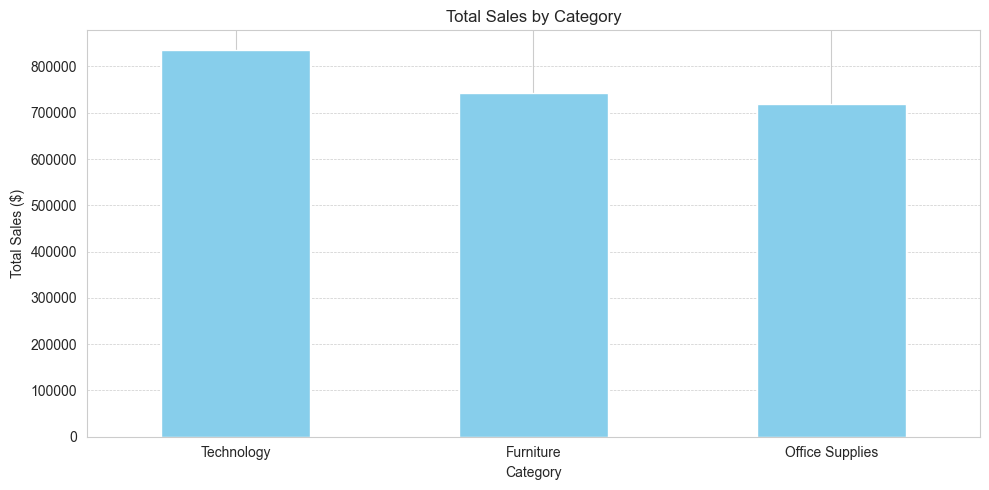


Generating Profit by Category plot...
Saved plot: plots/category_profit.png


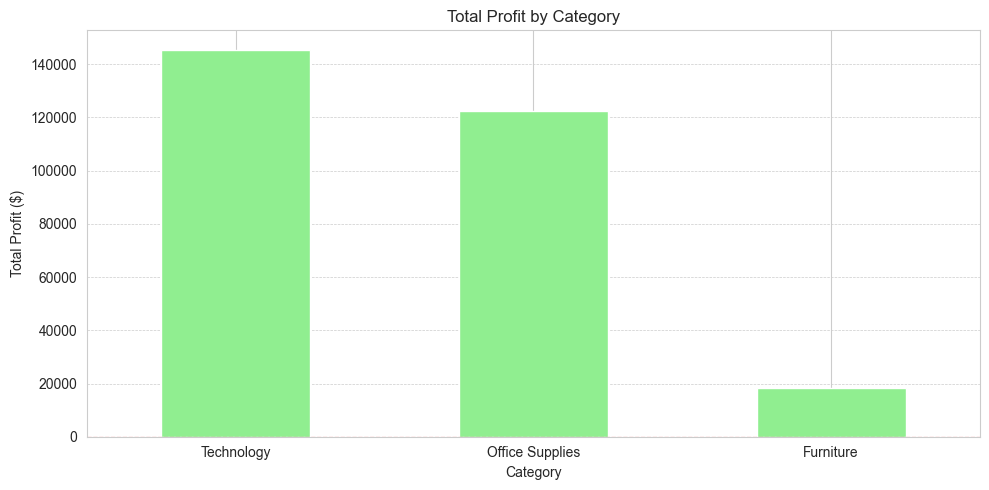


Generating Sales by Sub-Category plot...
Saved plot: plots/sub_category_sales.png


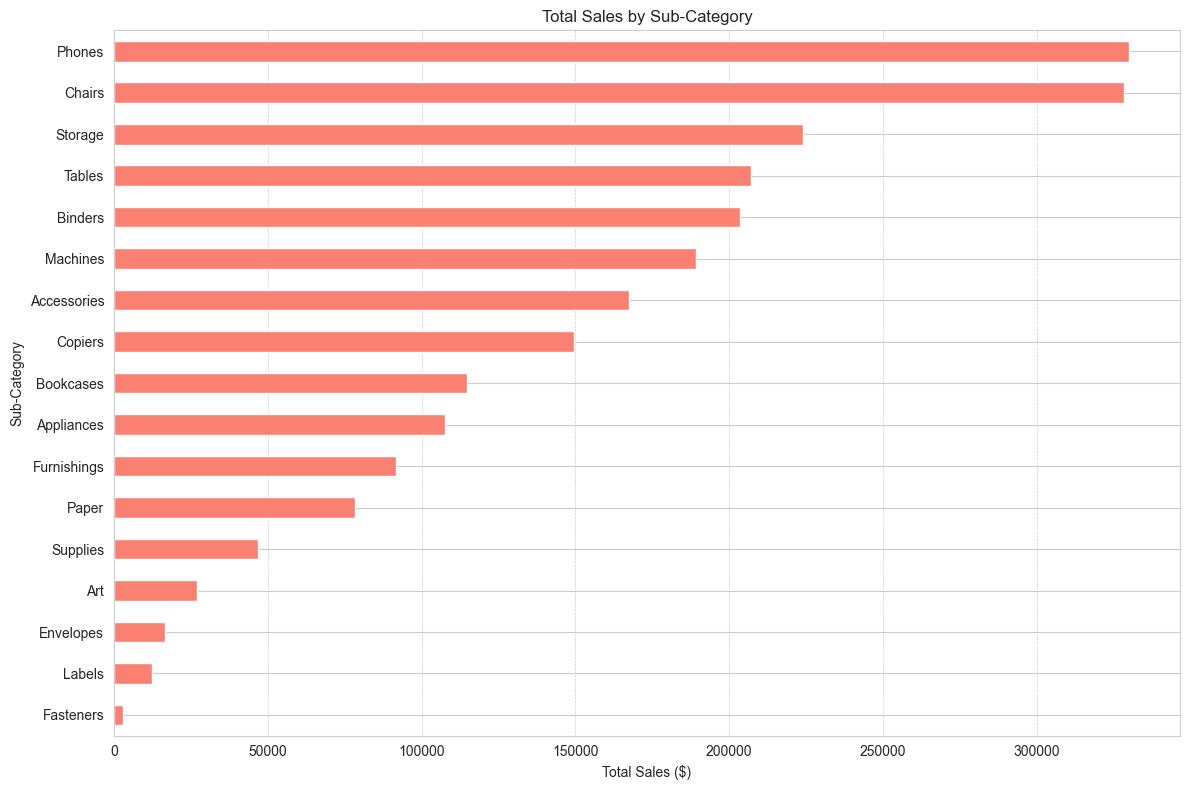


--- Category/Sub-Category Analysis Finished ---


In [16]:
# --- Category & Sub-Category Analysis ---
print("\n--- Category and Sub-Category Analysis ---")

# Check if df exists before proceeding
if 'df' in locals() and not df.empty:

    # Ensure required columns exist
    if 'category' in df.columns and 'sub_category' in df.columns and 'sales' in df.columns and 'profit' in df.columns:

        # --- Sales by Category ---
        print("Generating Sales by Category plot...")
        category_sales = df.groupby('category')['sales'].sum().sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        category_sales.plot(kind='bar', color='skyblue')
        plt.title('Total Sales by Category')
        plt.xlabel('Category')
        plt.ylabel('Total Sales ($)')
        plt.xticks(rotation=0) # Keep category names horizontal
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'category_sales.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

        # --- Profit by Category ---
        print("\nGenerating Profit by Category plot...")
        category_profit = df.groupby('category')['profit'].sum().sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        category_profit.plot(kind='bar', color='lightgreen')
        plt.title('Total Profit by Category')
        plt.xlabel('Category')
        plt.ylabel('Total Profit ($)')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Zero profit line
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'category_profit.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

        # --- Sales by Sub-Category ---
        print("\nGenerating Sales by Sub-Category plot...")
        sub_category_sales = df.groupby('sub_category')['sales'].sum().sort_values(ascending=True) # Sort ascending for horizontal bar

        plt.figure(figsize=(12, 8)) # Make figure taller for more sub-categories
        sub_category_sales.plot(kind='barh', color='salmon') # Horizontal bar chart
        plt.title('Total Sales by Sub-Category')
        plt.xlabel('Total Sales ($)')
        plt.ylabel('Sub-Category')
        plt.grid(axis='x', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'sub_category_sales.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

    else:
        print("Required columns ('category', 'sub_category', 'sales', 'profit') not found. Skipping category analysis.")

else:
    print("DataFrame 'df' not found or is empty. Skipping category analysis.")

print("\n--- Category/Sub-Category Analysis Finished ---")


--- Sub-Category Profit, Segment & Region Analysis ---
Generating Profit by Sub-Category plot...
Saved plot: plots/sub_category_profit.png


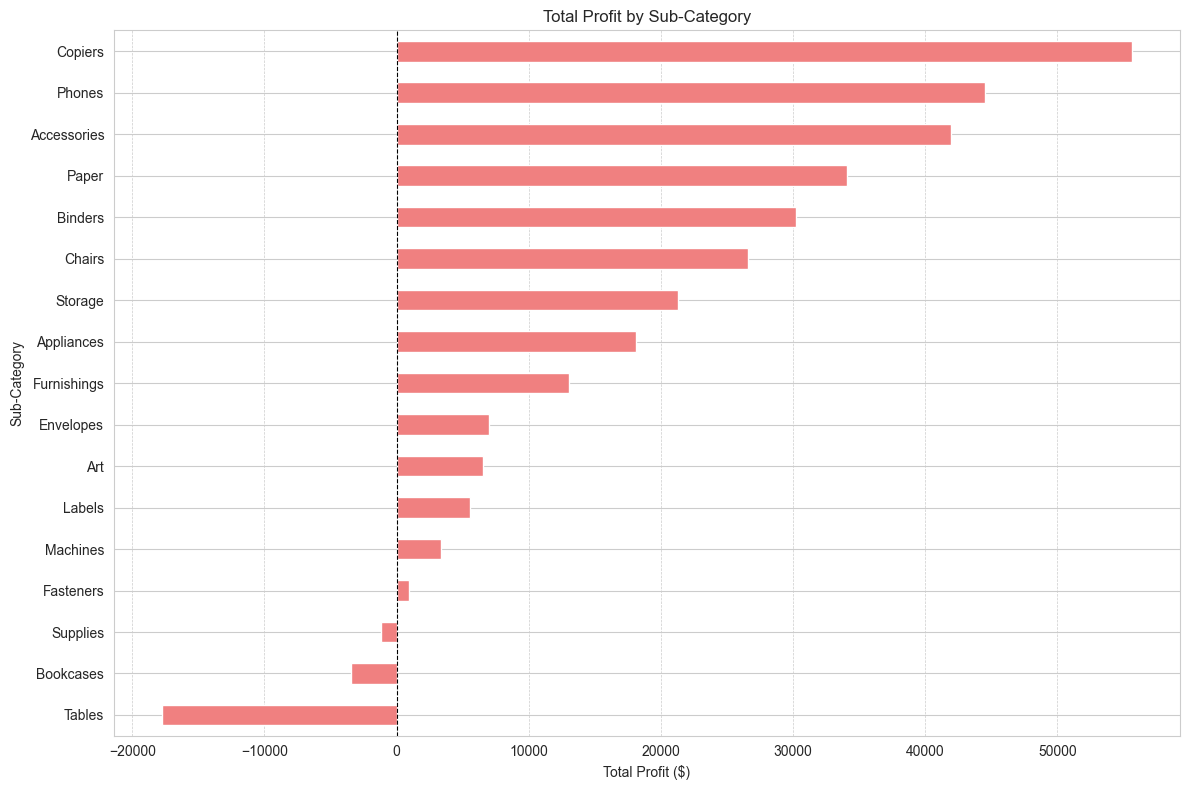


Generating Sales by Segment plot...
Saved plot: plots/segment_sales_pie.png


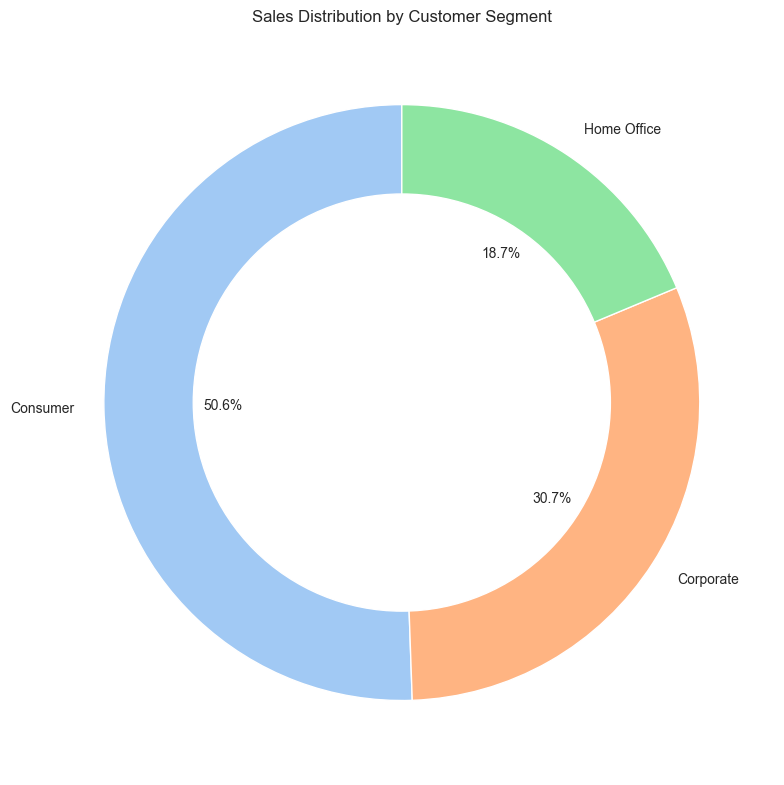


Generating Sales by Region plot...
Saved plot: plots/region_sales.png


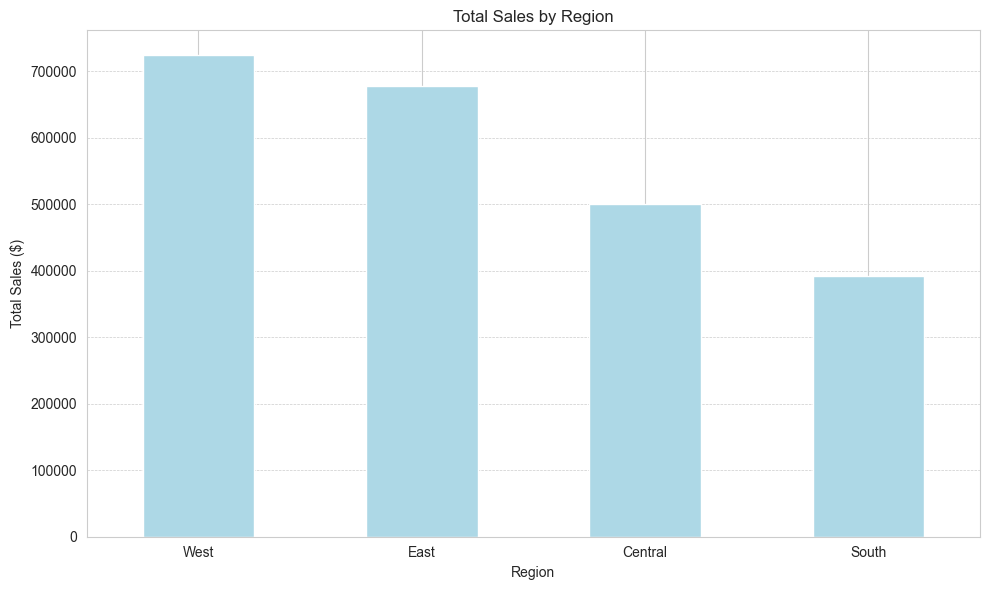


--- Sub-Category/Segment/Region Analysis Finished ---


In [17]:
# --- Sub-Category Profit, Segment & Region Analysis ---
print("\n--- Sub-Category Profit, Segment & Region Analysis ---")

# Check if df exists before proceeding
if 'df' in locals() and not df.empty:

    # Ensure required columns exist
    required_cols = ['sub_category', 'profit', 'segment', 'region', 'sales']
    if all(col in df.columns for col in required_cols):

        # --- Profit by Sub-Category ---
        print("Generating Profit by Sub-Category plot...")
        sub_category_profit = df.groupby('sub_category')['profit'].sum().sort_values(ascending=True) # Sort ascending for horizontal bar

        plt.figure(figsize=(12, 8))
        sub_category_profit.plot(kind='barh', color='lightcoral') # Horizontal bar chart
        plt.title('Total Profit by Sub-Category')
        plt.xlabel('Total Profit ($)')
        plt.ylabel('Sub-Category')
        plt.axvline(0, color='black', linestyle='--', linewidth=0.8) # Zero profit line
        plt.grid(axis='x', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'sub_category_profit.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

        # --- Sales by Segment (Pie Chart) ---
        print("\nGenerating Sales by Segment plot...")
        segment_sales = df.groupby('segment')['sales'].sum()

        plt.figure(figsize=(8, 8))
        plt.pie(segment_sales, labels=segment_sales.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
        plt.title('Sales Distribution by Customer Segment')

        # Draw circle for donut chart look (optional, from original script)
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'segment_sales_pie.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

        # --- Sales by Region (Bar Chart) ---
        print("\nGenerating Sales by Region plot...")
        region_sales = df.groupby('region')['sales'].sum().sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        region_sales.plot(kind='bar', color='lightblue')
        plt.title('Total Sales by Region')
        plt.xlabel('Region')
        plt.ylabel('Total Sales ($)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'region_sales.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

    else:
        print(f"One or more required columns missing ({required_cols}). Skipping analysis.")

else:
    print("DataFrame 'df' not found or is empty. Skipping analysis.")

print("\n--- Sub-Category/Segment/Region Analysis Finished ---")


--- 5. Correlation Analysis ---
Calculating correlation matrix...

Correlation Matrix:
             sales  quantity  discount    profit
sales     1.000000  0.200795 -0.028190  0.479064
quantity  0.200795  1.000000  0.008623  0.066253
discount -0.028190  0.008623  1.000000 -0.219487
profit    0.479064  0.066253 -0.219487  1.000000

Generating correlation heatmap...
Saved plot: plots/correlation_heatmap.png


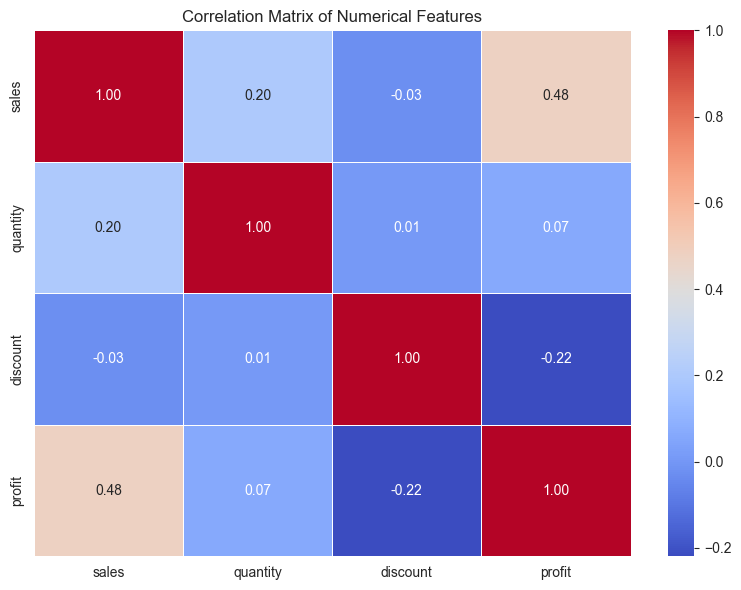


--- Superstore Analysis Script Finished ---


In [18]:
# --- 5. Correlation Analysis ---
print("\n--- 5. Correlation Analysis ---")

# Check if df exists before proceeding
if 'df' in locals() and not df.empty:

    # Select only numerical columns for correlation calculation
    # Ensure columns exist before trying to select them
    numerical_cols = ['sales', 'quantity', 'discount', 'profit']
    if all(col in df.columns for col in numerical_cols):
        numerical_df = df[numerical_cols]

        print("Calculating correlation matrix...")
        correlation_matrix = numerical_df.corr()

        print("\nCorrelation Matrix:")
        print(correlation_matrix)

        # Visualize the correlation matrix as a heatmap
        print("\nGenerating correlation heatmap...")
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        # annot=True displays the correlation values on the map
        # cmap='coolwarm' uses a blue-to-red color scheme
        # fmt=".2f" formats the numbers to two decimal places
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()

        # Save and show
        plot_path = os.path.join(output_dir, 'correlation_heatmap.png')
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
        plt.show()
        plt.close()

    else:
        print(f"One or more required numerical columns missing ({numerical_cols}). Skipping correlation analysis.")

else:
    print("DataFrame 'df' not found or is empty. Skipping correlation analysis.")

# Add a final print statement like in the original script
print("\n--- Superstore Analysis Script Finished ---")
